# Merging SDFITS Files

This recipe shows how to merge SDFITS files. 
There is no built-in function to merge SDFITS files (yet), so we will put the files we want to merge in the same directory, and then load them and write them to a single SDFITS file.
For this recipe we will use a single SDFITS file to generate two files from subsets of its data.

The following dysh commands are (re)introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sdf.summary()
      sdf.getps()
      sdf.write()
      

## Loading Modules
We start by loading the modules we will use for this recipe. 

In [1]:
# These modules are required for loading and writing data.
from dysh.fits import GBTFITSLoad
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(test="getps")

10:47:02.202 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use 
[GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad)
to load the data, and then its 
[summary](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.summary)
method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Writing SDFITS Files

To show how to merge SDFITS files, we will create two separate SDFITS files first.
We use the 
[GBTFITSLoad.write](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.write)
method to write the data.
We will write scans 51 and 52 to two separate files.

### Create an Output Directory

The approach we will use to merge SDFITS files relies on having the files to be merged in the same directory.
We create a new temporary directory ``./output/merge_sdfits`` 

In [6]:
tmp_dir = output_dir / "merge_sdfits"
tmp_dir.mkdir(exist_ok=True, parents=True) # Create the output directory if it does not exist.

### Write the Intermediate SDFITS Files

Now we write scans 51 and 52 to the directory we created.

In [7]:
sdfits.write(tmp_dir / "scan51.fits", scan=51, overwrite=True)
sdfits.write(tmp_dir / "scan52.fits", scan=52, overwrite=True)

 ID    TAG    SCAN # SELECTED
--- --------- ---- ----------
  0 196310aa0   51         44
 ID    TAG    SCAN # SELECTED
--- --------- ---- ----------
  0 344f3c7c1   52         44


## Merge SDFITS Files

Now that we have two SDFITS files we want to merge, we can do this by loading them using 
[GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad)
by passing the directory containing the files we want to merge.
In this case, that would be ``./output/merge_sdfits``.

In [8]:
sdfits_merged = GBTFITSLoad(tmp_dir)
sdfits_merged.files

10:47:02.677 I Loaded 2 FITS files


[PosixPath('/home/teuben/GBT/dysh/notebooks/examples/output/merge_sdfits/scan51.fits'),
 PosixPath('/home/teuben/GBT/dysh/notebooks/examples/output/merge_sdfits/scan52.fits')]

In [9]:
sdfits_merged.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872


### Write the Merged SDFITS Files to a New File

Now we can write the merged SDFITS files to a new file using 
[GBTFITSLoad.write](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.write)
We tell it to write to a single file with the ``multifile=False`` argument.
We write to a new directory to show that this is only one file now.

In [10]:
new_dir = output_dir / "merged_sdfits"
new_dir.mkdir(exist_ok=True)

In [11]:
sdfits_merged.write(new_dir / "merged_sdfits.fits", multifile=False, overwrite=True)

Load the merged SDFITS file. 

In [12]:
sdfits_merged = GBTFITSLoad(new_dir)        # BAD -> final getps spectrum is all 0 - TSCALE related?
sdfits_merged.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872


You can check that it is indeed a single file by looking at the ``files`` attribute of the ``GBTFITSLoad`` object.

In [13]:
sdfits_merged.files

[PosixPath('/home/teuben/GBT/dysh/notebooks/examples/output/merged_sdfits/merged_sdfits.fits')]

The same principles can be applied to more complex examples, like selecting an IF for certain scans, and another for others, and then merging them all in a single file.

## Final Stats

We then use
[getps](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.getps)
to obtain two spectra, which using the 
[Spectrum.stats()](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.stats)
should give the same answer 

In [28]:
sdfits.getps(ifnum=0,plnum=0,fdnum=0)[0].timeaverage().stats()  # rms 0.09109935 K

{'mean': <Quantity 0.28071181 K>,
 'median': <Quantity 0.28010114 K>,
 'rms': <Quantity 0.09109935 K>,
 'min': <Quantity -1.50458101 K>,
 'max': <Quantity 1.20767885 K>,
 'npt': 32768,
 'nan': 0}

In [15]:
# currently failing with 0
sdfits_merged.getps(ifnum=0,plnum=0,fdnum=0).timeaverage().stats()

{'mean': <Quantity 0. K>,
 'median': <Quantity 0. K>,
 'rms': <Quantity 0. K>,
 'min': <Quantity 0. K>,
 'max': <Quantity 0. K>,
 'npt': 32768,
 'nan': 0}

102

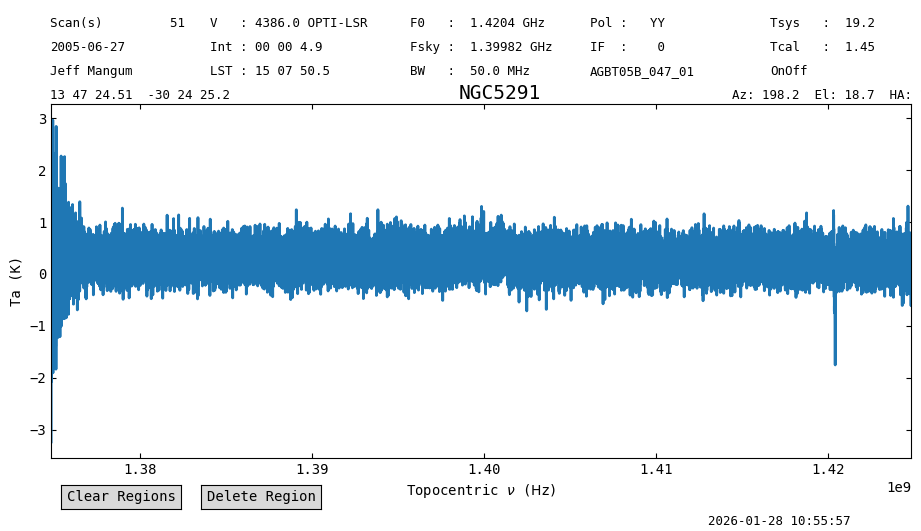

In [25]:
sp1 = sdfits.getps(ifnum=0,plnum=0,fdnum=0)[0].getspec(0)
sp1.plot()
sp1.meta
# 102

{'OBJECT': 'NGC5291',
 'BANDWID': 50000000.0,
 'DATE-OBS': '2005-06-27T02:05:58.00',
 'DURATION': 5.0475,
 'EXPOSURE': 4.885520696640015,
 'TSYS': 19.97095305915709,
 'TDIM7': '(32768,1,1,1)',
 'TUNIT7': 'K',
 'CTYPE1': 'FREQ-OBS',
 'CRVAL1': 1399816838.1210938,
 'CRPIX1': 16385.0,
 'CDELT1': -1525.87890625,
 'CTYPE2': 'RA',
 'CRVAL2': 206.8521075771953,
 'CTYPE3': 'DEC',
 'CRVAL3': -30.40701531088535,
 'CRVAL4': -6,
 'OBSERVER': 'Jeff Mangum',
 'OBSID': 'unknown',
 'SCAN': 51,
 'OBSMODE': 'OnOff:PSWITCHON:TPWCAL',
 'FRONTEND': 'Rcvr1_2',
 'TCAL': 1.4526499509811401,
 'VELDEF': 'OPTI-LSR',
 'VFRAME': 22609.232181632025,
 'RVSYS': 4376523.966595529,
 'OBSFREQ': 1399816838.1210938,
 'LST': 54470.49953792763,
 'AZIMUTH': 198.1588901992111,
 'ELEVATIO': 18.69449298449073,
 'TAMBIENT': 292.54999999999995,
 'PRESSURE': 697.7295162882529,
 'HUMIDITY': 0.754,
 'RESTFREQ': 1420405000.0,
 'FREQRES': 1846.3134765625,
 'EQUINOX': 2000.0,
 'RADESYS': 'FK5',
 'TRGTLONG': 206.85199999999995,
 'TRGTLA

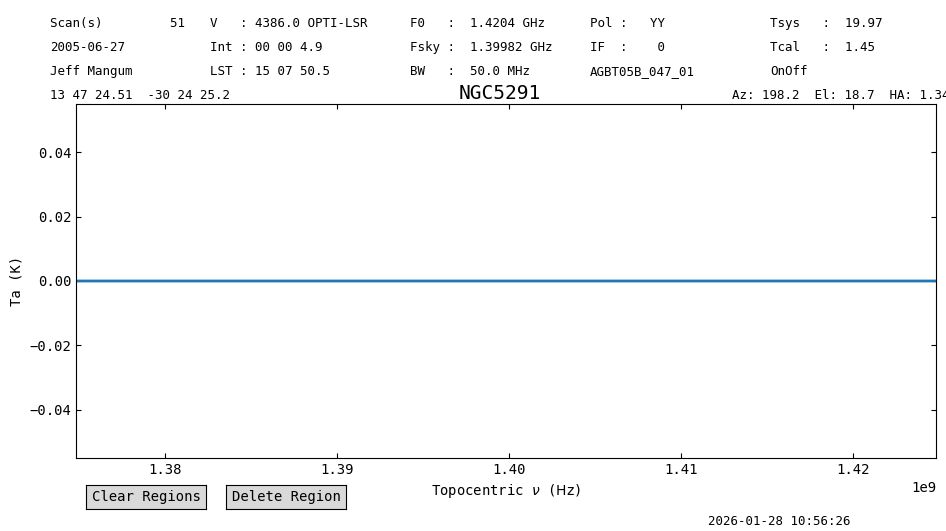

In [27]:
sp2 = sdfits_merged.getps(ifnum=0,plnum=0,fdnum=0)[0].getspec(0)
sp2.plot()
sp2.meta
# 104

10:47:04.525 I Missing TSCALE: patching Y-axis as 'Unknown (())'
10:47:04.622 I Missing TSCALE: patching Y-axis as 'Unknown (())'


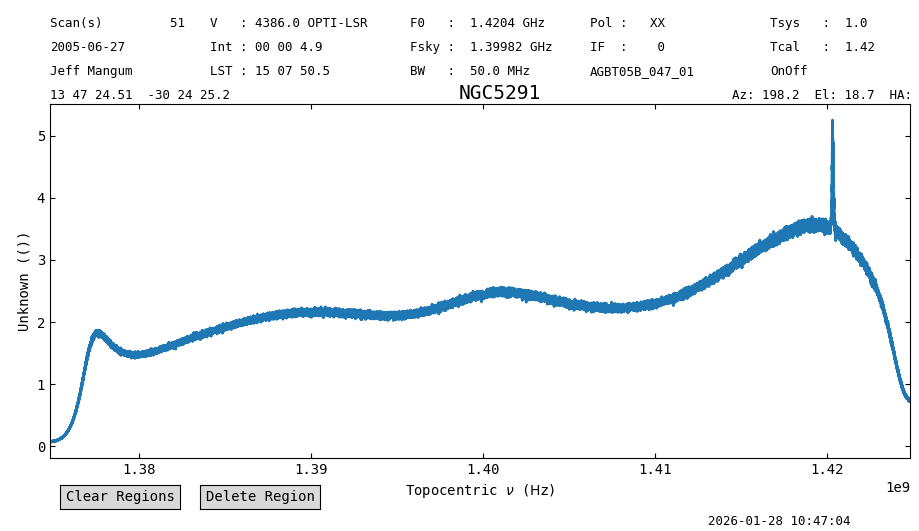

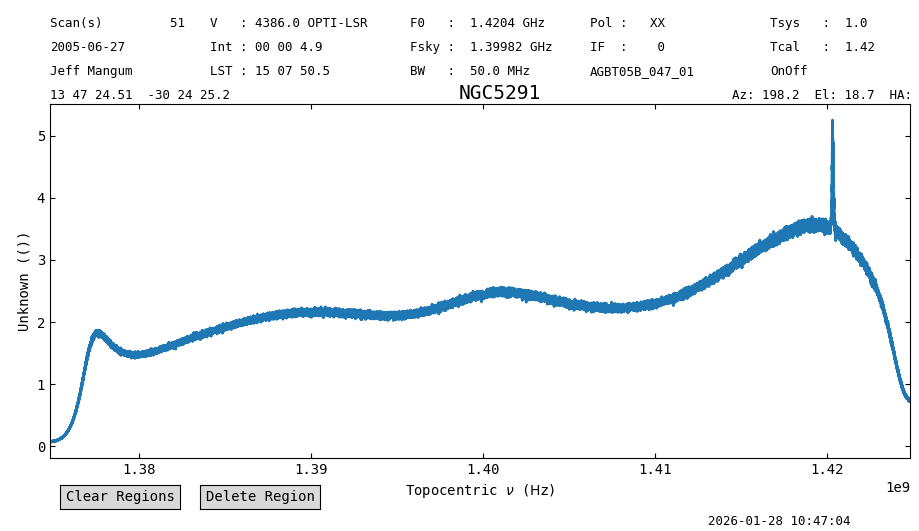

In [16]:
sdfits.getspec(0).plot()
sdfits_merged.getspec(0).plot()

In [17]:
d = sdfits.getspec(0)  - sdfits_merged.getspec(0)
d.stats()

{'mean': <Quantity 0. ct>,
 'median': <Quantity 0. ct>,
 'rms': <Quantity 0. ct>,
 'min': <Quantity 0. ct>,
 'max': <Quantity 0. ct>,
 'npt': 32768,
 'nan': 0}

## See Also

There is also an example of writing multiple SDFITS files in the `dataIO` notebook
[here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/dataIO.ipynb#Writing-SDFITS-to-Multiple-Files)


https://dysh-test.readthedocs.io/en/docs-quickstart/tutorials/examples/positionswitch.html

https://dysh.readthedocs.io/en/latest/tutorials/examples/positionswitch.html
